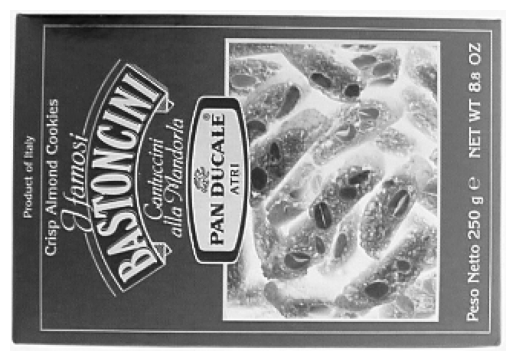

In [35]:
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow
import numpy as np
import numpy.typing as npt


def get_image(filename: str) -> np.array:
    dir = "images/"
    image = Image.open(dir + filename)
    image_array = np.array(image)
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    plt.axis('off')
    imshow(array, cmap=mode)


show_image(get_image('box.png'))

In [36]:
def scale(img: npt.NDArray[int], multiplier: int):
    h, w = img.shape
    h //= multiplier
    w //= multiplier

    result_image = np.zeros((h, w), dtype=int)

    for i in range(0, h):
        for j in range(0, w):
            result_image[i, j] = int(
                np.mean(img[i * multiplier : (i + 1) * multiplier, j * multiplier : (j + 1) * multiplier])
            )

    return result_image

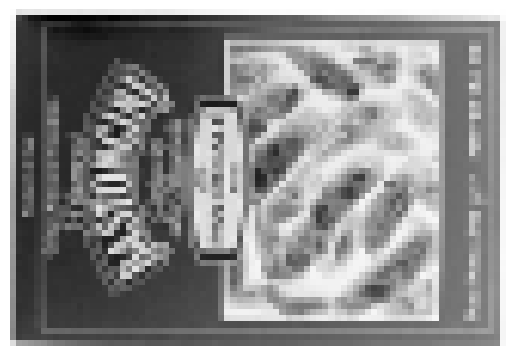

In [37]:
box = get_image("box.png")
test_image = get_image("box_in_scene.png")
box_x2 = scale(box, 2)
box_x4 = scale(box_x2, 2)
show_image(box_x4)

In [38]:
def get_gaussian(size: int, sigma: float = 0.84089642) -> npt.NDArray[float]:
    pad = size // 2

    K = np.zeros((size, size), np.float64)
    for x in range(-pad, -pad + size):
        for y in range(-pad, -pad + size):
            K[x + pad, y + pad] = np.exp(-(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
    return K

In [39]:
def fast(image, r, t):

    h, w = image.shape

    features = []
    for i in range(r // 2, h - r // 2):
        for j in range(r // 2, w - r // 2):
            p = image[i, j]
            low_arc = np.concatenate(
                (
                    image[i : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i : i + 2, j + 3],
                ),
                axis=None,
            )
            right_arc = np.concatenate(
                (
                    image[i + 3, j : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j : j + 2],
                ),
                axis=None,
            )
            full_arc = np.concatenate(
                (
                    image[i - 1 : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j - 1 : j + 2],
                    image[i - 2, j - 2],
                ),
                axis=None,
            )
            count = 0
            if all(q > p + t for q in low_arc) or all(q > p + t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    # два прохода, чтобы рассмотреть стык в начале окружнсти
                    if q > p + t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        features.append((i, j))
                        break
            elif all(q < p - t for q in low_arc) or all(q < p - t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    if q < p - t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        features.append((i, j))
                        break
    return features

In [40]:
# fast_box = fast(box, 3, 30)
# fast_box_x2 = fast(box_x2, 3, 30)
# fast_box_x4 = fast(box_x4, 3, 30)
# fast_test = fast(test_image, 3, 30)

In [41]:
fast_box = fast(box, 31, 30)
fast_box_x2 = fast(box_x2, 31, 30)
fast_box_x4 = fast(box_x4, 31, 30)
fast_test = fast(test_image, 31, 30)

In [42]:
def get_W(sigma2):
    # попробовать заменить на свой гауссиан
    const1 = 2 * sigma2
    const2 = 2 * np.pi * sigma2

    G = np.zeros((5, 5), dtype=np.float64)

    for i in range(5):
        for j in range(5):
            G[i, j] = np.power(np.e, -((i - 3) ** 2 + (j - 3) ** 2) / const1) / const2

    G /= np.sum(G)
    return G

In [43]:
W = get_W(100)
# print(W)

In [44]:
def get_gradient(image):
    h, w = image.shape

    img_copy = np.zeros((h + 1, w + 1), dtype=int)

    for i in range(h):
        for j in range(w):
            img_copy[i + 1, j + 1] = image[i, j]

    gradient = np.zeros((h + 1, w + 1, 2), dtype=float)

    for i in range(1, h):
        for j in range(1, w):
            gradient[i, j, 0] = (
                img_copy[i + 1, j]
                - img_copy[i - 1, j]
                + img_copy[i + 1, j - 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i - 1, j + 1]
            ) / 6
            gradient[i, j, 1] = (
                img_copy[i, j + 1]
                - img_copy[i, j - 1]
                + img_copy[i - 1, j + 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i + 1, j - 1]
            ) / 6

    return gradient[1 : h + 1, 1 : w + 1]

In [45]:
grad_box = get_gradient(box)
grad_box_x2 = get_gradient(box_x2)
grad_box_x4 = get_gradient(box_x4)

In [46]:
grad_test = get_gradient(test_image)

In [47]:
def get_M(I, grad, u, v):
    w = I.shape[0]
    h = I.shape[1]

    print(I)
    Icopy = np.zeros((w + 4, h + 4), dtype=int)
    Icopy[2 : w + 2, 2 : h + 2] = I

    M = np.zeros((2, 2), dtype=float)
    for i in range(u - 2, u + 3):
        for j in range(v - 2, v + 3):
            Ix = grad[i, j, 0]
            Iy = grad[i, j, 1]
            A = np.array([[Ix**2, Ix * Iy], [Ix * Iy, Iy**2]], dtype=float)
            A.shape = (2, 2)
            new = np.sum(W * Icopy[i - 2 + 2 : i + 3 + 2, j - 2 + 2 : j + 3 + 2]) * A
            M = np.add(M, new)
    return M

In [48]:
def get_M_for_all_points(image, grad, F):
    M = []
    for p in F:
        x, y = p
        m = get_M(image, grad, x, y)
        M.append(m)
    return M

In [49]:
M_box = get_M_for_all_points(box, grad_box, fast_box)
M_box_x2 = get_M_for_all_points(box, grad_box_x2, fast_box_x2)
M_box_x4 = get_M_for_all_points(box, grad_box_x4, fast_box_x4)

[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ... 16 15 14]
 ...
 [17 17 18 ... 19 21 13]
 [18 19 14 ... 19 18 18]
 [17 16 18 ... 19 18 18]]
[[21 18 25 ... 13 14 18]
 [22 20 18 ... 16 15 14]
 [18 20 12 ...

In [50]:
M_test = get_M_for_all_points(test_image, grad_test, fast_test)

[[ 44  44  47 ... 127 126 129]
 [ 43  46  45 ... 127 127 128]
 [ 44  47  44 ... 128 128 128]
 ...
 [ 25  21  21 ...  57  55  49]
 [ 21  26  26 ...  63  61  54]
 [ 27  25  24 ...  50  51  59]]
[[ 44  44  47 ... 127 126 129]
 [ 43  46  45 ... 127 127 128]
 [ 44  47  44 ... 128 128 128]
 ...
 [ 25  21  21 ...  57  55  49]
 [ 21  26  26 ...  63  61  54]
 [ 27  25  24 ...  50  51  59]]
[[ 44  44  47 ... 127 126 129]
 [ 43  46  45 ... 127 127 128]
 [ 44  47  44 ... 128 128 128]
 ...
 [ 25  21  21 ...  57  55  49]
 [ 21  26  26 ...  63  61  54]
 [ 27  25  24 ...  50  51  59]]
[[ 44  44  47 ... 127 126 129]
 [ 43  46  45 ... 127 127 128]
 [ 44  47  44 ... 128 128 128]
 ...
 [ 25  21  21 ...  57  55  49]
 [ 21  26  26 ...  63  61  54]
 [ 27  25  24 ...  50  51  59]]
[[ 44  44  47 ... 127 126 129]
 [ 43  46  45 ... 127 127 128]
 [ 44  47  44 ... 128 128 128]
 ...
 [ 25  21  21 ...  57  55  49]
 [ 21  26  26 ...  63  61  54]
 [ 27  25  24 ...  50  51  59]]
[[ 44  44  47 ... 127 126 129]
 [ 43  46

На основе значения критерия R = det(M) - k*(tr(M))^2 принять решение о фильтрации ключевой точки. Параметр k выбрать из интервала [0.04, 0.06].

In [51]:
def get_R(m, k):
    r = np.linalg.det(m) - k * np.trace(m) ** 2
    return r

In [52]:
def get_R_for_all_points(M, k):
    R = []
    for m in M:
        r = get_R(m, k)
        R.append(r)
    return R

In [53]:
k = 0.04
R_box = get_R_for_all_points(M_box, k)
R_box_x2 = get_R_for_all_points(M_box_x2, k)
R_box_x4= get_R_for_all_points(M_box_x4, k)
print(R_box)
print(R_box_x2)
print(R_box_x4)

[48752548321.349, 12199110878.145203, 7835435395.362488, 64774643100.56204, 100106573597.27751, -42097296725.32037, -11265122845.12915, 62508557225.08627, -99523682216.94421, 291208126951.9541, 344725449392.9909, 317801306238.6805, 4242066132445.5845, 97311589916.62741, 220975685307.59192, 3185372646682.7856, -616623551022.167, 20537771232.678024, 394896646869.943, 47521894150.5959, 37923299058.122025, 4021919089721.674, 552992995319.9906, 5219566316563.054, 8742918508999.178, 3928179132879.215, 673610708216.3608, 372122204552.4504, 847858080399.6704, 770186671590.094, 167293050275.6402, 230100894013.00604, 4158629394143.133, 3532191028181.767, -121982070588.11823, 5105803240473.722, -128689484128.97536, 1346147014324.1865, 139203229043.78378, -109514203735.52744, 15422936519.641113, 94434528797.34741, 12722750579.54966, -91726451208.87341, 57640158437.05591, -36438210016.0, 416207712433.7741, -101480805675.7353, -216407081210.61957, 229110800893.29468, 257976117721.0129, 495495777936.

In [54]:
R_test = get_R_for_all_points(M_test, k)
print(R_test)

[1057173554.5175824, 1057776649.7257429, 1062387832026.5302, 502036455685.0815, 1436952446324.4595, 389515166689.3182, 268438966827.75385, 185426004190.13986, 2397622700410.5503, 1330210064676.1401, 2332470161343.4785, 1168438858646.7952, 4559935357.219865, 1491813616063.4092, 1198271294142.546, 1627939912298.974, 800220881724.7643, 1725437760264.3296, 2070505414946.87, 1605927462108.5964, 979976186499.0518, 2758686927837.551, 1934019738036.399, 1115308048273.835, 361039036853.245, 2717871075842.456, 2308580763529.051, 295972470851.8971, 769700141693.8677, 900401804658.6741, 1048500417456.9038, 655442820875.6089, 75559379334.14134, 585475211599.6643, 52684138630.49763, 854326708206.1737, 1083599541030.6896, 572361407791.9967, 1371920108057.8066, 833882290532.5088, 2697686991780.5186, 386255822867.50037, 444927021085.8307, 129239217384.38342, 1593951542997.1455, 1855366275957.2808, 643060319512.7388, -183894211897.53946, 1402905074398.9512, 546293801067.8213, 2338951356207.062, 19395024

Отфильтровать точки по убыванию значения критерия Харриса и выбрать первые N точек.

In [55]:
def Harris_filtering(F, R, N):
    point_R = dict()
    for i in range(len(F)):
        point_R[F[i]] = R[i]

    d = dict(sorted(point_R.items(), key=lambda item: item[1], reverse=True)[0:N])
    m = N
    for key in reversed(list(d.keys())):
        if d[key] >= 0:
            break
        m -= 1
    points = list(d.keys())[0:m]
    return points

In [56]:
points_box = Harris_filtering(fast_box, R_box, 500)
points_box_x2 = Harris_filtering(fast_box_x2, R_box_x2, len(fast_box_x2))
points_box_x4 = Harris_filtering(fast_box_x4, R_box_x4, len(fast_box_x4))
# print(len(points_box), points_box)
# print(len(F12), len(points_box_x2), points_box_x2)
# print(len(F14), len(points_box_x4), points_box_x4)

In [57]:
points_test = Harris_filtering(fast_test, R_test, 500)
# print(len(points_test), points_test)

In [58]:
def get_image_with_points(img: npt.NDArray[int], points: npt.NDArray[int]) -> npt.NDArray[int]:
    h, w = img.shape
    result_image = np.zeros((h, w, 3), dtype=int)
    result_image[:, :, 0] = img[:, :]
    result_image[:, :, 1] = img[:, :]
    result_image[:, :, 2] = img[:, :]

    point_color = (255, 0, 0)
    figure()
    for p in points:
        i, j = p
        result_image[i - 1 : i + 1, j - 1 : j + 1] = point_color

    return result_image

<Figure size 640x480 with 0 Axes>

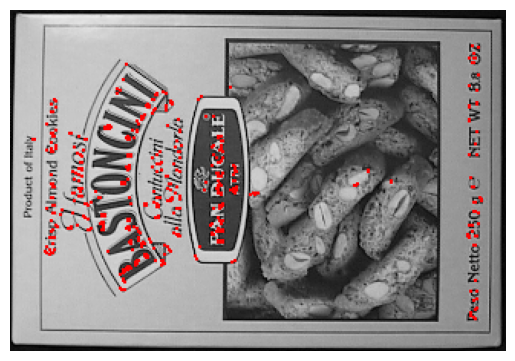

<Figure size 640x480 with 0 Axes>

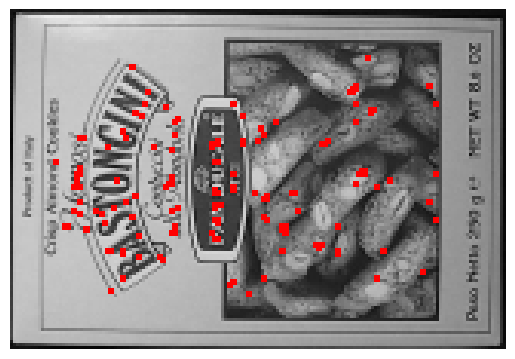

<Figure size 640x480 with 0 Axes>

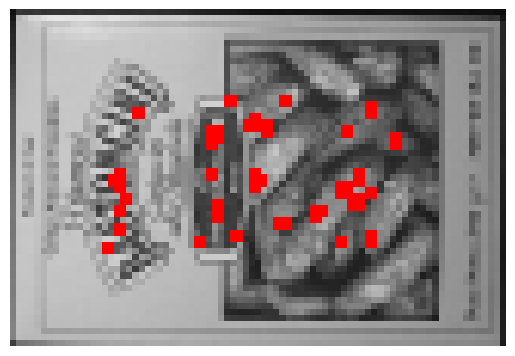

<Figure size 640x480 with 0 Axes>

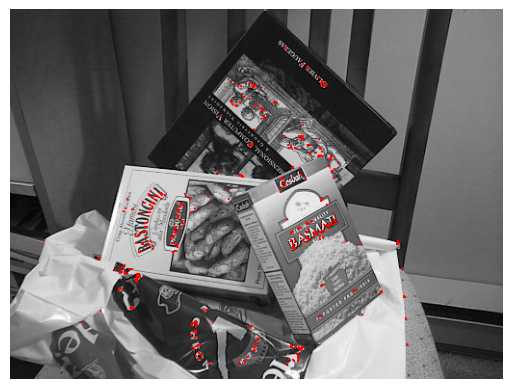

In [59]:
show_image(get_image_with_points(box, points_box))
show_image(get_image_with_points(box_x2, points_box_x2))
show_image(get_image_with_points(box_x4, points_box_x4))
show_image(get_image_with_points(test_image, points_test))